# BNP Paribas Stock Price HMM Analysis

This notebook:
1. Reads and cleans BNP Paribas stock price data.
2. Computes log returns.
3. Fits a Gaussian Hidden Markov Model (HMM) with `n_components=10` hidden states.
4. Stores the learned model in Neo4j (states, transitions).
5. Demonstrates a function for forecasting log returns.
6. Finally, adds simulation and comparison with actual data for the first 100 observations.

Comments are added in each cell to clarify the process.

In [1]:
# %%
# Step 1: Load libraries and read CSV
import pandas as pd
import numpy as np

# Read BNP Paribas data
data_bnp = pd.read_csv('../data/BNPPA.csv')

# Convert 'Date' column to datetime
data_bnp['Date'] = pd.to_datetime(data_bnp['Date'])

# Sort values by date
data_bnp.sort_values('Date', inplace=True)

# Reset index after sorting
data_bnp.reset_index(drop=True, inplace=True)

# 1) Filter invalid or missing close prices
data_bnp = data_bnp[data_bnp['Close'].notna()]      # remove rows missing close
data_bnp = data_bnp[data_bnp['Close'] > 0]          # remove zero or negative

# 2) Compute log prices & returns
data_bnp['LogClose'] = np.log(data_bnp['Close'])
data_bnp['LogRet']   = data_bnp['LogClose'].diff()

# 3) Replace inf and drop NaNs that result (e.g., from diff of the first row)
data_bnp.replace([np.inf, -np.inf], np.nan, inplace=True)
data_bnp.dropna(subset=['LogRet'], inplace=True)

# Display final cleaned dataframe
data_bnp

,Date,Open,High,Low,Close,Adj Close,Volume,LogClose,LogRet
1,1993-10-19,21.129074,21.228039,20.832178,20.881660,3.838838,8760516.0,3.038871,-0.025732
2,1993-10-20,20.881660,21.129074,20.782696,21.030109,3.866129,6174815.0,3.045955,0.007084
3,1993-10-21,20.980625,21.376488,20.980625,21.376488,3.929806,8263391.0,3.062292,0.016336
4,1993-10-22,21.425970,21.970278,21.376488,21.871313,4.020774,10181091.0,3.085176,0.022884
5,1993-10-25,21.821831,22.019760,21.673384,21.920795,4.029871,4038109.0,3.087436,0.002260
...,...,...,...,...,...,...,...,...,...
7517,2022-12-06,52.250000,52.529999,51.849998,52.459999,52.459999,1969471.0,3.960051,0.002672
7518,2022-12-07,52.349998,52.639999,51.730000,52.000000,52.000000,2131657.0,3.951244,-0.008807
7519,2022-12-08,52.259998,52.349998,51.860001,52.000000,52.000000,1764207.0,3.951244,0.000000
7520,2022-12-09,52.299999,52.889999,51.860001,52.889999,52.889999,2243527.0,3.968214,0.016971


In [2]:
# %%
# Final check and transform observations into 2D array for HMM
observations = data_bnp['LogRet'].values.reshape(-1, 1)
if np.isnan(observations).any() or np.isinf(observations).any():
    raise ValueError("Observations still contain NaN or Inf - check data pipeline.")

observations

array([[-0.02573248],
       [ 0.00708391],
       [ 0.01633645],
       ...,
       [ 0.        ],
       [ 0.01697055],
       [-0.00397839]])

In [3]:
# %%
# Connect to Neo4j and clear any existing data
from py2neo import Graph
# Make sure to replace the auth with your correct credentials
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

# Clear existing graph data
graph.run("MATCH (n) DETACH DELETE n")


(No data)

In [4]:
# %%
# Import hmmlearn and create the GaussianHMM
from hmmlearn import hmm

# Let's choose 10 hidden states
n_components = 10

# Instantiate a GaussianHMM
model = hmm.GaussianHMM(
    n_components=n_components,
    covariance_type='full',  # 'full' means a full covariance matrix
    n_iter=100,             # Maximum number of EM iterations
    random_state=42         # For reproducibility
)

# Fit (train) the model to the data using the Baum-Welch algorithm
model.fit(observations)

print("Model has been trained.")

Model has been trained.


In [5]:
# %%
# Decode hidden states using the Viterbi algorithm
# hidden_states[i] will be the most likely hidden state index on day i

hidden_states = model.predict(observations)

# Extract important parameters
start_probs = model.startprob_        # shape = (n_components,)
trans_probs = model.transmat_         # shape = (n_components, n_components)
means = model.means_.flatten()        # shape = (n_components,)
covars = model.covars_                # shape depends on covariance_type

# Display the transition matrix, rounded to 3 decimals
transition_matrix = model.transmat_
transition_matrix_3dec = np.round(transition_matrix, 3)
print("Transition Matrix (3 decimals):")
print(transition_matrix_3dec)

Transition Matrix (3 decimals):
[[0.447 0.    0.    0.    0.    0.    0.    0.439 0.    0.114]
 [0.37  0.    0.    0.    0.    0.    0.455 0.175 0.    0.   ]
 [0.    0.009 0.    0.    0.    0.    0.    0.022 0.969 0.   ]
 [0.226 0.    0.    0.708 0.067 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.172 0.77  0.    0.004 0.    0.054]
 [0.    0.    0.    0.    0.973 0.    0.    0.    0.    0.027]
 [0.    0.    0.164 0.    0.    0.    0.    0.    0.836 0.   ]
 [0.    0.    0.008 0.014 0.    0.    0.001 0.978 0.    0.   ]
 [0.    0.    0.843 0.    0.    0.    0.127 0.    0.029 0.   ]
 [0.    0.    0.    0.045 0.    0.    0.    0.    0.    0.955]]


In [6]:
# %%
# 5. Save the HMM in Neo4j
#
# A) Create a parent node for the entire HMM.
# B) Create nodes for each hidden state and store mean, variance, start prob.
# C) Create relationships representing transition probabilities.

graph.run("MATCH (n) DETACH DELETE n")
hmm_name = "BNP_HMM"
create_hmm_query = f"""
MERGE (h:HMM {{name: $hmm_name}})
ON CREATE SET h.description = "GaussianHMM with {n_components} hidden states"
RETURN h
"""
# Create or update the parent HMM node
graph.run(create_hmm_query, hmm_name=hmm_name)

# B) Create nodes for each state
for i in range(n_components):
    # For 'full' covariance and 1D data, covars[i] is a 1x1 matrix.
    # We'll store just the diagonal (variance) as a float.
    if covars[i].ndim > 1:
        var_value = covars[i].diagonal().mean()
    else:
        var_value = covars[i]

    create_state_query = f"""
    MERGE (s:State {{hmm_name: $hmm_name, state_index: $state_index}})
    ON CREATE SET
      s.mean = $mean,
      s.variance = $variance,
      s.start_prob = $start_prob
    RETURN s
    """

    graph.run(
        create_state_query,
        hmm_name=hmm_name,
        state_index=i,
        mean=float(means[i]),
        variance=float(var_value),
        start_prob=float(start_probs[i])
    )

# C) Create relationships for transition probabilities
for i in range(n_components):
    for j in range(n_components):
        prob_ij = float(trans_probs[i, j])
        create_rel_query = f"""
        MATCH (s1:State {{hmm_name: $hmm_name, state_index: $i}}),
              (s2:State {{hmm_name: $hmm_name, state_index: $j}})
        MERGE (s1)-[r:TRANSITION_TO {{prob: $prob_ij}}]->(s2)
        RETURN r
        """
        graph.run(create_rel_query, hmm_name=hmm_name, i=i, j=j, prob_ij=prob_ij)

print("HMM parameters have been stored in Neo4j.")

HMM parameters have been stored in Neo4j.


In [7]:
# %%
# 6. Posterior probabilities & Forecast function
#
# 'predict_proba()' gives the posterior state probabilities at each time step.
# Then we define a forecast function that uses a weighted average of means.

# Retrieve posterior probabilities for each day/state
posterior_probs = model.predict_proba(observations)

def forecast_log_returns(start_probs, transmat, means, steps=5):
    """
    start_probs: posterior probability distribution over states for the last known day
    transmat: transition matrix from the fitted HMM
    means: array of shape (n_components,) - mean log return per state
    steps: how many steps ahead to forecast

    This function evolves the distribution over states using the Markov chain.
    Then at each step, computes a weighted average of the state's mean log returns.
    """
    # Copy to avoid mutating the input
    dist = start_probs.copy()
    forecasts = []

    for step in range(steps):
        # Weighted average log return for the current distribution over states
        forecast_r = np.sum(dist * means)
        forecasts.append(forecast_r)

        # Evolve the distribution by 1 time step via matrix multiplication
        dist = dist @ transmat

    return forecasts

# Example usage: predict 5-day-ahead average log returns based on the final distribution
last_day_probs = posterior_probs[-1, :]
multi_step_logret = forecast_log_returns(
    start_probs=last_day_probs,
    transmat=model.transmat_,
    means=model.means_.flatten(),
    steps=5
)
print("Predicted log returns for the next 5 days:", multi_step_logret)

Predicted log returns for the next 5 days: [3.078583626915954e-05, 0.00029459668405386525, 1.9497845638561074e-05, 0.0003182895132913165, 5.7425660716908675e-05]


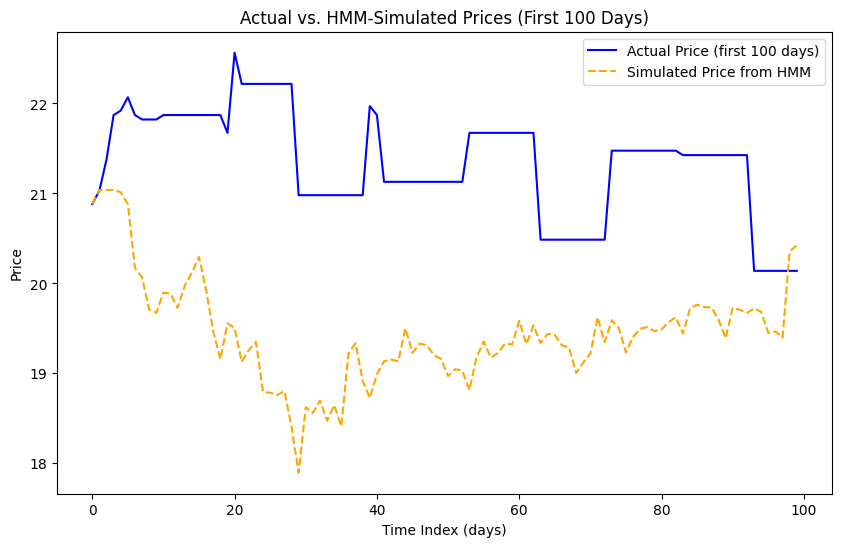

In [8]:
# %%
# 7. Simulate the first 100 observations and compare vs actual data
#
# We'll do a generative simulation of the HMM for 100 steps, starting
# from a sampled initial state (according to startprob_). We'll then
# compare that simulated price path with the actual first 100 day prices.

import matplotlib.pyplot as plt
import math

def simulate_hmm(model, n=100):
    """
    Generates a synthetic sequence of hidden states and observations
    from a trained HMM.

    Parameters:
        model: a fitted hmm.GaussianHMM instance
        n: number of time steps to simulate

    Returns:
        sim_states: array of length n with the sampled hidden states
        sim_obs:    array of length n with the sampled log returns
    """
    # Extract key parameters
    start_probs = model.startprob_       # shape: (n_components,)
    trans_probs = model.transmat_        # shape: (n_components, n_components)
    means = model.means_                 # shape: (n_components, n_features)
    covars = model.covars_               # depends on covariance_type

    n_states = model.n_components

    # 1) Sample initial hidden state from the model's start probabilities
    state = np.random.choice(range(n_states), p=start_probs)
    sim_states = [state]
    sim_obs = []

    # 2) Draw the first observation from the state's Gaussian
    if model.covariance_type == 'full':
        std_dev = math.sqrt(covars[state, 0, 0])
    else:  # 'diag' or other type
        std_dev = math.sqrt(covars[state, 0])

    obs = np.random.normal(loc=means[state, 0], scale=std_dev)
    sim_obs.append(obs)

    # 3) Iteratively sample next hidden states and observations
    for _ in range(n - 1):
        # Sample next state based on transition probabilities of the current state
        state = np.random.choice(range(n_states), p=trans_probs[state])
        sim_states.append(state)

        # Sample observation from the chosen state's Gaussian
        if model.covariance_type == 'full':
            std_dev = math.sqrt(covars[state, 0, 0])
        else:
            std_dev = math.sqrt(covars[state, 0])

        obs = np.random.normal(loc=means[state, 0], scale=std_dev)
        sim_obs.append(obs)

    return np.array(sim_states), np.array(sim_obs)

# --- Perform the simulation ---
sim_length = 100
sim_states, sim_obs = simulate_hmm(model, n=sim_length)

# Convert simulated log returns to prices
# We'll start from the same initial price as the actual data on day 0
actual_prices_100 = data_bnp['Close'].values[:sim_length]
initial_price = actual_prices_100[0]

simulated_prices = [initial_price]
for i in range(1, sim_length):
    # Price_t = Price_(t-1) * e^(sim_obs[i])
    next_price = simulated_prices[-1] * np.exp(sim_obs[i])
    simulated_prices.append(next_price)

# --- Plot Actual vs Simulated (Generative) ---
plt.figure(figsize=(10, 6))
plt.plot(range(sim_length), actual_prices_100, label='Actual Price (first 100 days)', color='blue')
plt.plot(range(sim_length), simulated_prices, label='Simulated Price from HMM', color='orange', linestyle='--')
plt.title("Actual vs. HMM-Simulated Prices (First 100 Days)")
plt.xlabel("Time Index (days)")
plt.ylabel("Price")
plt.legend()
plt.show()
